# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [1]:
#Import Packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import yfinance as yf
import numpy.random as npr
import math
import seaborn as sns
npr.seed(42)
import scipy.stats as stats
sns.set_style('darkgrid')
import random

In [2]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return np.array(list(zip(edges, edges)))

def mergeOverlap(arr):
    #function taken from: https://www.geeksforgeeks.org/dsa/merging-intervals/
    n = len(arr)

    arr.sort()
    res = []

    # Checking for all possible overlaps
    for i in range(n):
        start = arr[i][0]
        end = arr[i][1]

        # Skipping already merged intervals
        if res and res[-1][1] >= end:
            continue

        # Find the end of the merged range
        for j in range(i + 1, n):
            if arr[j][0] <= end:
                end = max(end, arr[j][1])
        res.append([start, end])
    
    return res

def normal_subintervals(log_daily_returns, 
                        days_samples,
                        size_days_samples, 
                        len_interval_samples, 
                        size_interval_samples, 
                        min_len  ):
    ndays = len(log_daily_returns)

    li = size_interval_samples*ndays #(ndays - min_len)*ndays 
    intervals = np.zeros((li, 2))
    p_values = np.zeros(li)
    c = 0

    for n in len_interval_samples:
        for i in days_samples:
            if i< (len(log_daily_returns)-(n-1)) :
                intervals[c,:] = [i, (i+n)]
                partition_log_daily_returns = log_daily_returns[range(i, (i+n))]
                p_values[c] = stats.normaltest(partition_log_daily_returns)[1]
                c = c+1
    candidate_intervals = intervals[p_values>0.05,:]
    candidate_intervals = candidate_intervals.tolist()
    normal_intervals = np.array(mergeOverlap(candidate_intervals))
    candidate_intervals = np.array(candidate_intervals)
    if np.shape(candidate_intervals)[0]>1:
        #print("siii")
        candidate_intervals = candidate_intervals[candidate_intervals[:, 0].argsort()]
        candidate_intervals_OK = candidate_intervals

        i_1 = np.zeros(( (np.shape(candidate_intervals_OK)[0] )*(np.shape(candidate_intervals_OK)[0] )  , 3),dtype=int )
        c=0
        for i in range(np.shape(candidate_intervals_OK)[0]):
            for j in range(np.shape(candidate_intervals_OK)[0]):
                if j>i:
                    i_1[c,0] = i
                    i_1[c,1] = j
                    compare_sub_1 = candidate_intervals_OK[i, :]
                    compare_sub_2 = candidate_intervals_OK[j, :]
                    if compare_sub_1[0]>= compare_sub_2[0] and compare_sub_1[1] <= compare_sub_2[1]:
                        # print(compare_sub_1, compare_sub_2, "overlap")    
                        i_1[c,2] = 1
                c = c+1

        candidate_intervals_OK = np.delete(candidate_intervals_OK, (i_1[i_1[:,2]>0, 0]) , axis=0)
        candidate_intervals_OK = candidate_intervals_OK[candidate_intervals_OK[:,0].argsort()].astype(int)
        return candidate_intervals_OK
    else:
        return np.zeros((1,2))

## Solution

For the data exploration for the items 1, and 2, we are going to base the analyses on the NASDAQ composite index for a ten year period.

## 1, 2) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.

In [3]:
names_companies = ['^IXIC']
tickers = ['^IXIC']

end_date = '2025-06-25'
#start_date = dt.datetime.today()-dt.timedelta(days = 10*365)
start_date = pd.to_datetime(end_date) - dt.timedelta(days = 10*365)
#end_date = dt.datetime.today()
NASDAQ_index = yf.download(tickers, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


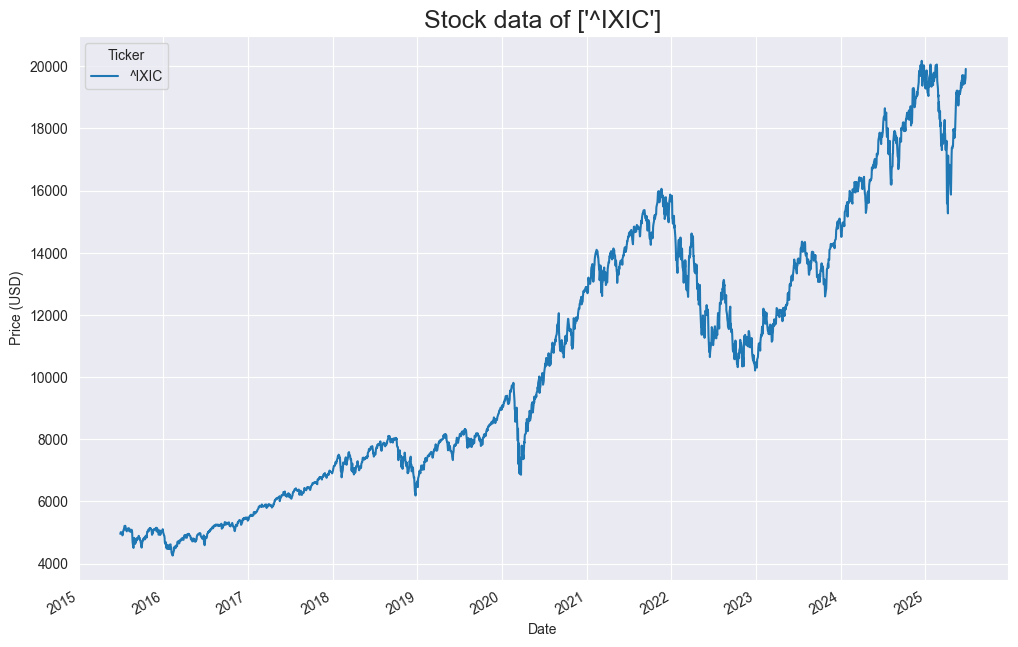

In [4]:
#Plot Closing Price stock data
NASDAQ_index['Close'][tickers].plot(figsize = (12,8))
plt.title(f'Stock data of {tickers}', size = 18)
plt.ylabel('Price (USD)')
plt.show()

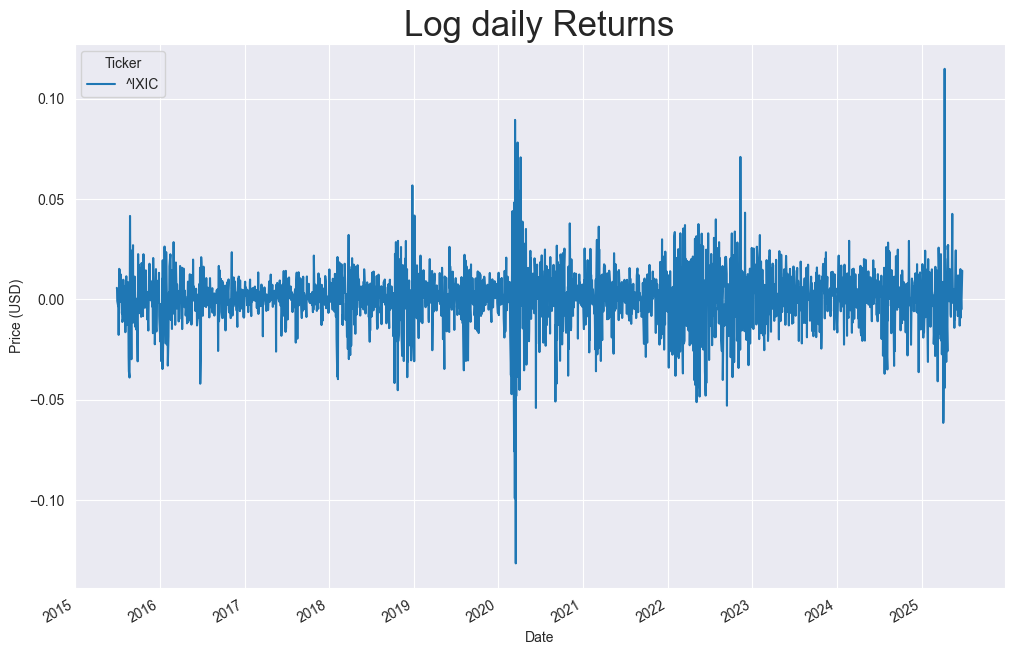

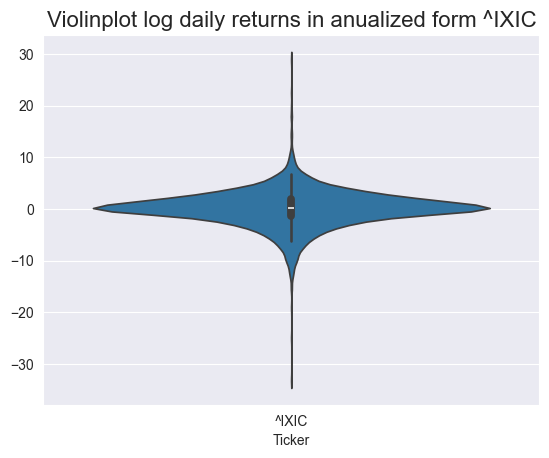

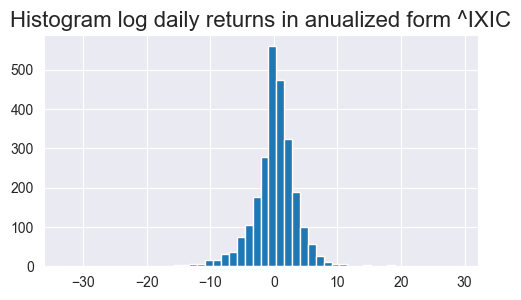

In [5]:
daily_returns_NASDAQ_index = NASDAQ_index['Close']/NASDAQ_index['Close'].shift(1)
log_daily_returns_NASDAQ_index = np.log(daily_returns_NASDAQ_index)
log_daily_returns_NASDAQ_index = log_daily_returns_NASDAQ_index.dropna()

log_daily_returns_NASDAQ_index[tickers].plot(figsize = (12,8))
plt.title(f'Log daily Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

sns.violinplot( data = log_daily_returns_NASDAQ_index*252, order=tickers)
plt.title('Violinplot log daily returns in anualized form ^IXIC', size=16)

(log_daily_returns_NASDAQ_index*252).hist(figsize=(5.6,3), bins=50)
plt.title('Histogram log daily returns in anualized form ^IXIC', size=16)
plt.show()

We going to explore within this time period for time intervals in which this index is normally distributed. For this, we are going to generate random partitions over the ten years period, calculate the p-values for each of those partitions, and cave the candidate set of partitions. After this, the algorithm merge the candidate subintervals. This is, for given intervals $[a, b], [c, d]$ if $[c,d] \subset [a,b]$  the algorithm will store the interval $[a, b]$ and remove $[c, d]$.

In [6]:
min_len_NASDAQ =  int(np.floor(252/3)) # 4 months
ndays_NASDAQ = len(log_daily_returns_NASDAQ_index)

size_interval_samples_NASDAQ = 50 
len_interval_samples_NASDAQ = np.sort(random.sample(range(min_len_NASDAQ, ndays_NASDAQ), size_interval_samples_NASDAQ)) 

size_days_samples_NASDAQ = 50
days_samples_NASDAQ = np.sort(random.sample(range(0, ndays_NASDAQ), size_days_samples_NASDAQ))  


In [7]:
log_daily_returns_NASDAQ_index_1= np.array(log_daily_returns_NASDAQ_index.iloc[:,0])

In [8]:
normal_candidate_intervals_NASDAQ = normal_subintervals(log_daily_returns= log_daily_returns_NASDAQ_index_1, 
                        days_samples=days_samples_NASDAQ,
                        size_days_samples=size_days_samples_NASDAQ, 
                        len_interval_samples =len_interval_samples_NASDAQ, 
                        size_interval_samples=size_interval_samples_NASDAQ, 
                        min_len=min_len_NASDAQ)

Returning p-values for all the normal subintervals produced by the sample:

In [9]:
for j in range(np.shape(normal_candidate_intervals_NASDAQ)[0]):
    historical_NASDAQ = log_daily_returns_NASDAQ_index_1[range(int(normal_candidate_intervals_NASDAQ[j,0]), int(normal_candidate_intervals_NASDAQ[j,1]) )]

    p_value = stats.normaltest(historical_NASDAQ)[1]

    n = int(normal_candidate_intervals_NASDAQ[j,1]) - int(normal_candidate_intervals_NASDAQ[j,0])

    print('-----------------------')
    print('From: ', log_daily_returns_NASDAQ_index.index.tolist()[int(normal_candidate_intervals_NASDAQ[j,0]) ] , ' To: ', log_daily_returns_NASDAQ_index.index.tolist()[int(normal_candidate_intervals_NASDAQ[j,1]) ])
    print('Number of days', { n} )
    print(f"Log return distribution: p-value = {p_value:.4f}")
    print("→ No statistically significant evidence against normality.")

-----------------------
From:  2015-06-30 00:00:00  To:  2016-03-08 00:00:00
Number of days {173}
Log return distribution: p-value = 0.0924
→ No statistically significant evidence against normality.
-----------------------
From:  2015-12-11 00:00:00  To:  2016-06-20 00:00:00
Number of days {130}
Log return distribution: p-value = 0.1067
→ No statistically significant evidence against normality.
-----------------------
From:  2015-12-30 00:00:00  To:  2016-05-02 00:00:00
Number of days {84}
Log return distribution: p-value = 0.3385
→ No statistically significant evidence against normality.
-----------------------
From:  2016-09-07 00:00:00  To:  2017-01-06 00:00:00
Number of days {84}
Log return distribution: p-value = 0.2031
→ No statistically significant evidence against normality.
-----------------------
From:  2018-08-30 00:00:00  To:  2019-01-02 00:00:00
Number of days {84}
Log return distribution: p-value = 0.0892
→ No statistically significant evidence against normality.
--------

Below we show the largest time interval:

In [10]:
len_days_NASDAQ = normal_candidate_intervals_NASDAQ[:,1]- normal_candidate_intervals_NASDAQ[:,0]
normal_interval_large_NASDAQ = normal_candidate_intervals_NASDAQ[len_days_NASDAQ==np.max(len_days_NASDAQ),:]

-----------------------
From:  2022-12-19 00:00:00  To:  2024-10-01 00:00:00
Number of days {448}
^Portfolio log return distribution: p-value = 0.1132
→ No statistically significant evidence against normality.


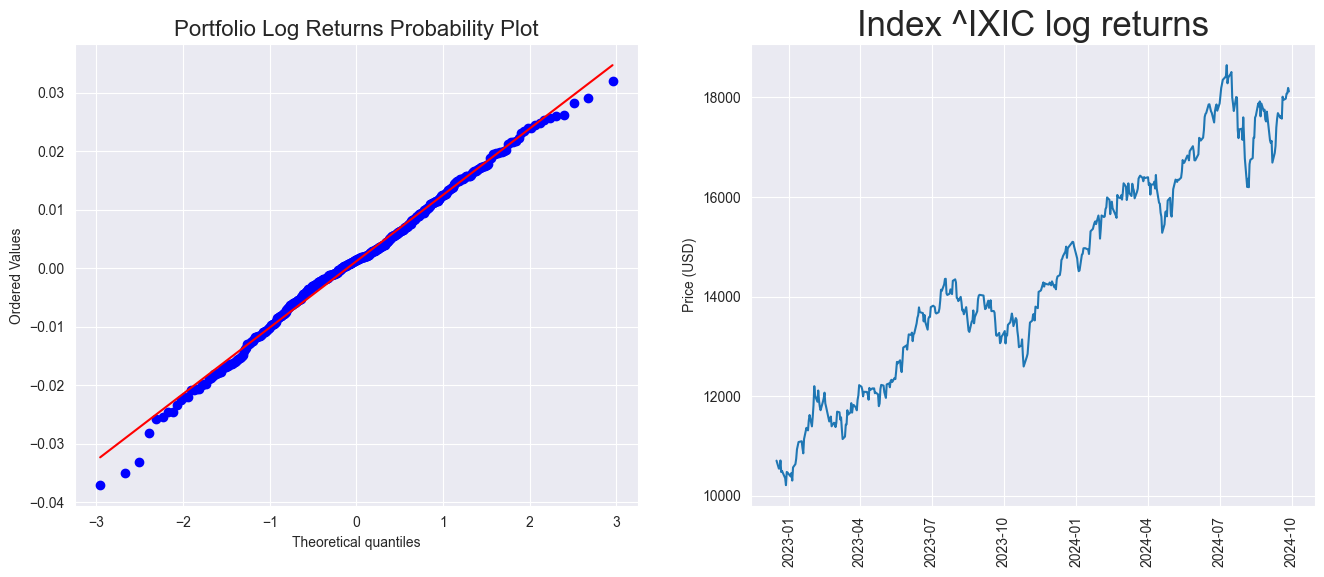

In [11]:
m_ind_NASDAQ = np.shape(normal_interval_large_NASDAQ)[0]-1
historical_NASDAQ = log_daily_returns_NASDAQ_index_1[range(int(normal_interval_large_NASDAQ[m_ind_NASDAQ,0]), int(normal_interval_large_NASDAQ[m_ind_NASDAQ,1]) )]

p_value = stats.normaltest(historical_NASDAQ)[1]
    
fig,axes = plt.subplots(1,2, figsize=(16, 6))
stats.probplot(historical_NASDAQ, plot = axes[0])
axes[0].set_title("Portfolio Log Returns Probability Plot", fontsize=16)
axes[0].grid(True)

n = int(normal_interval_large_NASDAQ[m_ind_NASDAQ,1]) - int(normal_interval_large_NASDAQ[m_ind_NASDAQ,0])+1
NASDAQ_historical = NASDAQ_index['Close'].iloc[range(int(normal_interval_large_NASDAQ[m_ind_NASDAQ,0]), int(normal_interval_large_NASDAQ[m_ind_NASDAQ,1]) )]
plt.plot(NASDAQ_historical)
plt.title(f'Index ^IXIC log returns', size = 25)
plt.ylabel('Price (USD)')
plt.xticks(fontsize=10, rotation=90)

plt.savefig("Figure1_p2.png")

print('-----------------------')
print('From: ', log_daily_returns_NASDAQ_index.index.tolist()[int(normal_interval_large_NASDAQ[m_ind_NASDAQ,0]) ] , ' To: ', log_daily_returns_NASDAQ_index.index.tolist()[int(normal_interval_large_NASDAQ[m_ind_NASDAQ,1]) ])
print('Number of days', { n} )
print(f"^Portfolio log return distribution: p-value = {p_value:.4f}")
print("→ No statistically significant evidence against normality.")

## 3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.

Portfolio composed of stocks from Alphabet, IBM, and Nvidia for a period of four years.

In [12]:
names_companies = ['Alphabet Inc.','International Business Machines Corporation','Nvidia' ]
tickers = ['GOOG', 'IBM', 'NVDA']
##
end_date = '2025-06-25'
start_date = pd.to_datetime(end_date) - dt.timedelta(days = 365*4)

##
#start_date = dt.datetime.today()-dt.timedelta(days = 4*365)
#end_date = dt.datetime.today()

stocks_personalized = yf.download(tickers, start = start_date, end=end_date)

log_daily_returns_personalized_individual = np.log(stocks_personalized['Close']/stocks_personalized['Close'].shift(1))
log_daily_returns_personalized_individual = log_daily_returns_personalized_individual.dropna()

log_daily_returns_personalized_pooled = log_daily_returns_personalized_individual.mean(axis=1)
log_daily_returns_personalized_pooled = np.array(log_daily_returns_personalized_pooled)

[*********************100%***********************]  3 of 3 completed


In [13]:
min_len_pers =  int(np.floor(252/3)) # 4 months
ndays_pers = len(log_daily_returns_personalized_pooled)

size_interval_samples_pers = 50 
len_interval_samples_pers = np.sort(random.sample(range(min_len_pers, ndays_pers), size_interval_samples_pers) ) 

size_days_samples_pers = 50
days_samples_pers = np.sort(random.sample(range(0, ndays_pers), size_interval_samples_pers) )  


In [14]:
normal_candidate_intervals_pers= normal_subintervals(log_daily_returns= log_daily_returns_personalized_pooled, 
                        days_samples=days_samples_pers,
                        size_days_samples=size_days_samples_pers, 
                        len_interval_samples =len_interval_samples_pers, 
                        size_interval_samples=size_interval_samples_pers, 
                        min_len=min_len_pers  )

Returning p-values for all the normal subintervals produced by the sample:

In [15]:
for j in range(np.shape(normal_candidate_intervals_pers)[0]):
    historical_pers = log_daily_returns_personalized_pooled[range(int(normal_candidate_intervals_pers[j,0]), int(normal_candidate_intervals_pers[j,1]) )]

    p_value_pers = stats.normaltest(historical_pers)[1]

    n = int(normal_candidate_intervals_pers[j,1]) - int(normal_candidate_intervals_pers[j,0])

    print('-----------------------')
    print('From: ', log_daily_returns_personalized_individual.index.tolist()[int(normal_candidate_intervals_pers[j,0]) ] , ' To: ', log_daily_returns_personalized_individual.index.tolist()[int(normal_candidate_intervals_pers[j,1]) ])
    print('Number of days', { n} )
    print(f"^Portfolio log return distribution: p-value = {p_value_pers:.4f}")
    print("→ No statistically significant evidence against normality.")

-----------------------
From:  2021-08-18 00:00:00  To:  2023-05-23 00:00:00
Number of days {443}
^Portfolio log return distribution: p-value = 0.1654
→ No statistically significant evidence against normality.
-----------------------
From:  2021-09-13 00:00:00  To:  2023-05-15 00:00:00
Number of days {420}
^Portfolio log return distribution: p-value = 0.2219
→ No statistically significant evidence against normality.
-----------------------
From:  2021-09-29 00:00:00  To:  2023-05-09 00:00:00
Number of days {404}
^Portfolio log return distribution: p-value = 0.2762
→ No statistically significant evidence against normality.
-----------------------
From:  2021-10-11 00:00:00  To:  2023-05-19 00:00:00
Number of days {404}
^Portfolio log return distribution: p-value = 0.3238
→ No statistically significant evidence against normality.
-----------------------
From:  2021-11-11 00:00:00  To:  2023-04-14 00:00:00
Number of days {356}
^Portfolio log return distribution: p-value = 0.4327
→ No stat

As before, we select the longest time interval: 

In [16]:
len_days_pers = normal_candidate_intervals_pers[:,1]- normal_candidate_intervals_pers[:,0]
normal_interval_large_pers = normal_candidate_intervals_pers[len_days_pers==np.max(len_days_pers),:]

-----------------------
From:  2021-08-18 00:00:00  To:  2023-05-23 00:00:00
Number of days {444}
^Portfolio log return distribution: p-value = 0.1654
→ No statistically significant evidence against normality.


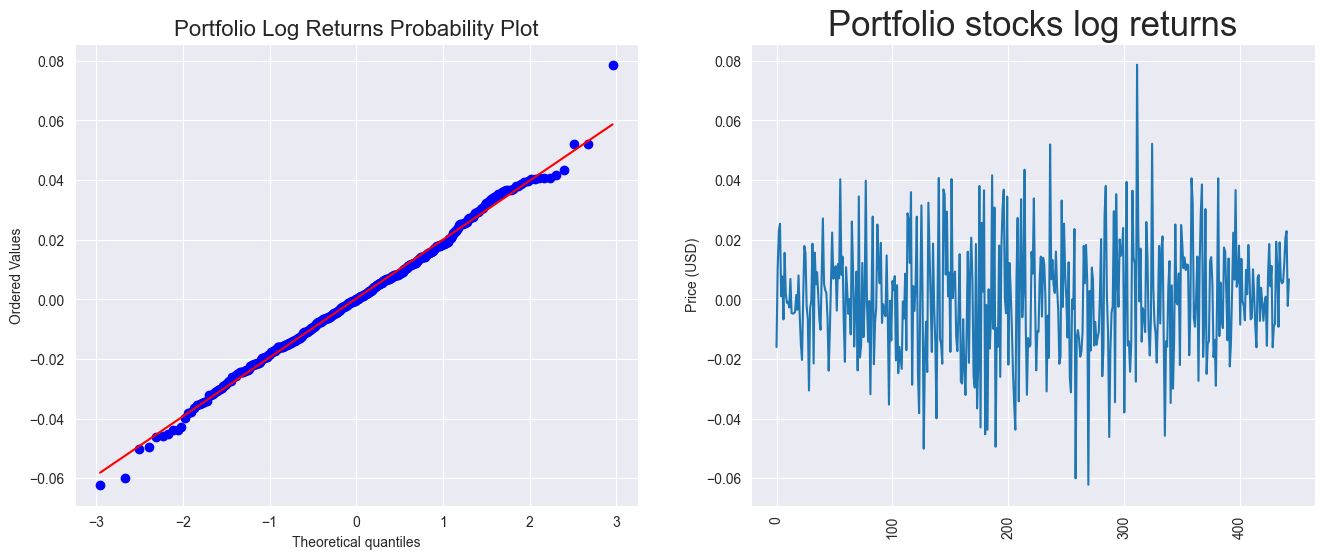

In [17]:
m_ind_pers = np.shape(normal_interval_large_pers)[0]-1
historical_pers = log_daily_returns_personalized_pooled[range(int(normal_interval_large_pers[m_ind_pers,0]), int(normal_interval_large_pers[m_ind_pers,1]) )]

p_value_pers = stats.normaltest(historical_pers)[1]
    
fig,axes = plt.subplots(1,2, figsize=(16, 6))
stats.probplot(historical_pers, plot = axes[0])
axes[0].set_title("Portfolio Log Returns Probability Plot", fontsize=16)
axes[0].grid(True)

n = int(normal_interval_large_pers[m_ind_pers,1]) - int(normal_interval_large_pers[m_ind_pers,0])+1
plt.plot(historical_pers)
plt.title(f'Portfolio stocks log returns', size = 25)
plt.ylabel('Price (USD)')
plt.xticks(fontsize=10, rotation=90)

print('-----------------------')
print('From: ', log_daily_returns_personalized_individual.index.tolist()[int(normal_interval_large_pers[m_ind_pers,0]) ] , ' To: ', log_daily_returns_personalized_individual.index.tolist()[int(normal_interval_large_pers[m_ind_pers,1]) ])
print('Number of days', { n} )
print(f"^Portfolio log return distribution: p-value = {p_value_pers:.4f}")
print("→ No statistically significant evidence against normality.")

## 4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.

In [18]:
names_companies = ['Fast Retailing Co., Ltd.','Alphabet Inc.','International Business Machines Corporation','JPMorgan Chase & Co.','Netflix, Inc.','Exxon Mobil Corporation','Yum! Brands, Inc.' ]
tickers = ['FRCOY', 'GOOG', 'IBM', 'JPM', 'NFLX', 'XOM', 'YUM']

##
end_date = '2025-06-25'
start_date = pd.to_datetime(end_date) - dt.timedelta(days = 365*2)

###
#start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
#end_date = dt.datetime.today()
#end_date = '2025-06-25'
stock = yf.download(tickers, start = start_date, end=end_date)

log_daily_returns_proj_1_individual = np.log(stock['Close']/stock['Close'].shift(1))
log_daily_returns_proj_1_individual = log_daily_returns_proj_1_individual.dropna()

log_daily_returns_proj_1_pooled = log_daily_returns_proj_1_individual.mean(axis=1)
log_daily_returns_proj_1_pooled = np.array(log_daily_returns_proj_1_pooled)

[*********************100%***********************]  7 of 7 completed


Portfolio Project 1 log return distribution: p-value = 0.0000
→ Statistically significant evidence that the data is NOT normally distributed.


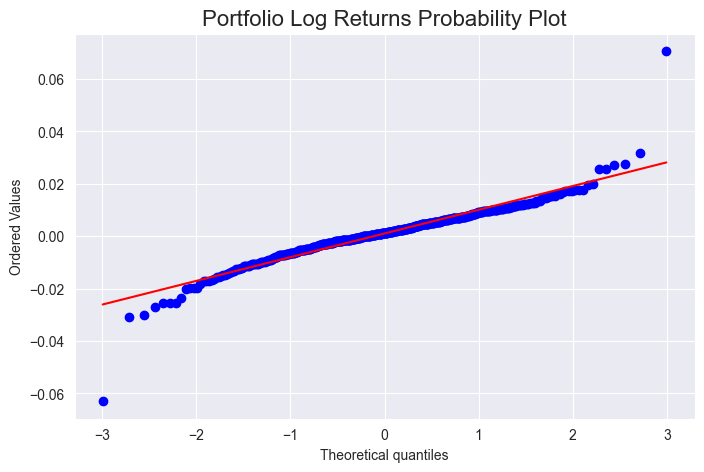

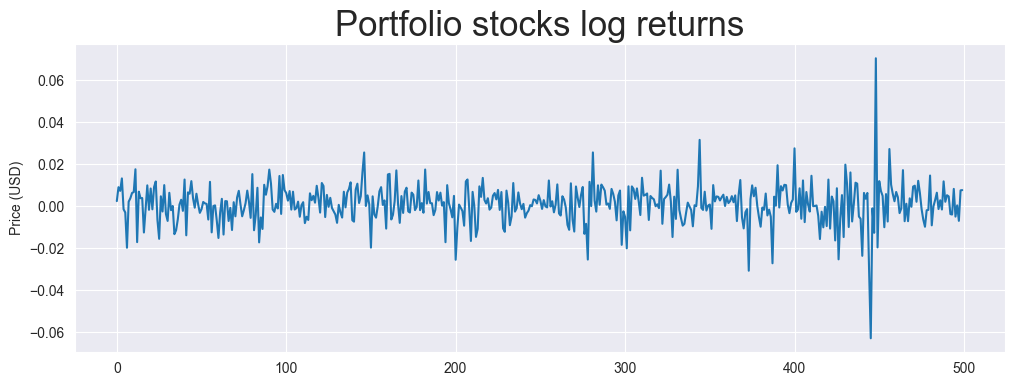

In [19]:
p_historical_proj_1 = stats.normaltest(log_daily_returns_proj_1_pooled)[1]

print(f"Portfolio Project 1 log return distribution: p-value = {p_historical_proj_1:.4f}")
if p_historical_proj_1 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

plt.figure(figsize=(8,5))
stats.probplot(log_daily_returns_proj_1_pooled, plot = plt)
plt.title("Portfolio Log Returns Probability Plot", fontsize=16)
plt.savefig("Figure2_p2.png")

plt.show()
plt.figure(figsize=(12,4))
plt.plot(log_daily_returns_proj_1_pooled)
plt.title(f'Portfolio stocks log returns', size = 25)
plt.ylabel('Price (USD)')
plt.savefig("Figure3_p2.png")

plt.show()

In [30]:
p_historical_proj_1

np.float64(2.850623625311775e-22)

According to the test, the porfolio for the miniproject is not normally distributed for the two years period. Now we will proceed to find periods in which this portfolio shows normality. 

In [20]:
min_len =  int(np.floor(252/3)) # 4 months
ndays = len(log_daily_returns_proj_1_pooled)

size_interval_samples = 50 
len_interval_samples = np.sort(random.sample(range(min_len, ndays), size_interval_samples) ) 

size_days_samples = 50
days_samples = np.sort(random.sample(range(0, ndays), size_days_samples) )  


In [21]:
normal_candidate_intervals= normal_subintervals(log_daily_returns= log_daily_returns_proj_1_pooled, 
                        days_samples=days_samples,
                        size_days_samples=size_days_samples, 
                        len_interval_samples =len_interval_samples, 
                        size_interval_samples=size_interval_samples, 
                        min_len=min_len  )

In [22]:
for j in range(np.shape(normal_candidate_intervals)[0]):
    historical_pooled = log_daily_returns_proj_1_pooled[range(int(normal_candidate_intervals[j,0]), int(normal_candidate_intervals[j,1]) )]

    p_value = stats.normaltest(historical_pooled)[1]

    n = int(normal_candidate_intervals[j,1]) - int(normal_candidate_intervals[j,0])

    print('-----------------------')
    print('From: ', log_daily_returns_proj_1_individual.index.tolist()[int(normal_candidate_intervals[j,0]) ] , ' To: ', log_daily_returns_proj_1_individual.index.tolist()[int(normal_candidate_intervals[j,1]) ])
    print('Number of days', { n} )
    print(f"^Portfolio log return distribution: p-value = {p_value:.4f}")
    print("→ No statistically significant evidence against normality.")

-----------------------
From:  2023-07-28 00:00:00  To:  2024-07-18 00:00:00
Number of days {244}
^Portfolio log return distribution: p-value = 0.0610
→ No statistically significant evidence against normality.
-----------------------
From:  2023-08-15 00:00:00  To:  2024-08-05 00:00:00
Number of days {244}
^Portfolio log return distribution: p-value = 0.1089
→ No statistically significant evidence against normality.
-----------------------
From:  2023-08-21 00:00:00  To:  2024-06-26 00:00:00
Number of days {213}
^Portfolio log return distribution: p-value = 0.0517
→ No statistically significant evidence against normality.
-----------------------
From:  2023-08-28 00:00:00  To:  2024-06-14 00:00:00
Number of days {201}
^Portfolio log return distribution: p-value = 0.0855
→ No statistically significant evidence against normality.
-----------------------
From:  2023-09-08 00:00:00  To:  2024-07-23 00:00:00
Number of days {218}
^Portfolio log return distribution: p-value = 0.0619
→ No stat

In [23]:
len_days = normal_candidate_intervals[:,1]- normal_candidate_intervals[:,0]
normal_interval_large = normal_candidate_intervals[len_days==np.max(len_days),:]

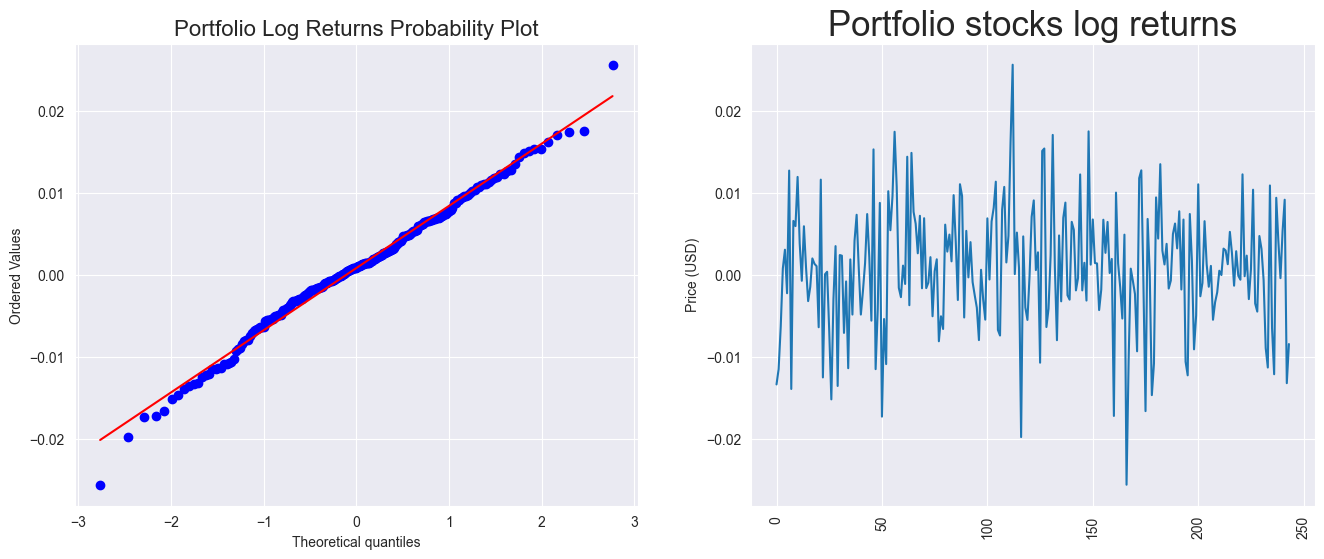

-----------------------
From:  2023-08-15 00:00:00  To:  2024-08-05 00:00:00
Number of days {245}
^Portfolio log return distribution: p-value = 0.1089
→ No statistically significant evidence against normality.


In [24]:
m_ind = np.shape(normal_interval_large)[0]-1
historical_pooled = log_daily_returns_proj_1_pooled[range(int(normal_interval_large[m_ind,0]), int(normal_interval_large[m_ind,1]) )]

p_value = stats.normaltest(historical_pooled)[1]
    
fig,axes = plt.subplots(1,2, figsize=(16, 6))
stats.probplot(historical_pooled, plot = axes[0])
axes[0].set_title("Portfolio Log Returns Probability Plot", fontsize=16)
axes[0].grid(True)

n = int(normal_interval_large[m_ind,1]) - int(normal_interval_large[m_ind,0])+1
plt.plot(historical_pooled)
plt.title(f'Portfolio stocks log returns', size = 25)
plt.ylabel('Price (USD)')
plt.xticks(fontsize=10, rotation=90)
plt.savefig("Figure4_p2.png")

plt.show()
print('-----------------------')
print('From: ', log_daily_returns_proj_1_individual.index.tolist()[int(normal_interval_large[m_ind,0]) ] , ' To: ', log_daily_returns_proj_1_individual.index.tolist()[int(normal_interval_large[m_ind,1]) ])
print('Number of days', { n} )
print(f"^Portfolio log return distribution: p-value = {p_value:.4f}")
print("→ No statistically significant evidence against normality.")

## 5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

For examining the historical stock data, we have taken the list of companies that belong to the SP500 index during a five years time period. We removed the companies for which data was not available for the whole time period. By simplicity, we run the algorithm and extract for each company the longest time interval normally distributed.

In [25]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

symbols_list = sorted(sp500['Symbol'].unique().tolist())

ind = [i for i in range(0, len(symbols_list)) if symbols_list[i] == "BRK.B" or symbols_list[i] == "BF.B"] #removing companies for which data is not available
symbols_list = [i for j, i in enumerate(symbols_list) if j not in ind]

end_date = '2025-06-25'
start_date = pd.to_datetime(end_date) - dt.timedelta(days = 365*5)


index_sp500 = yf.download(tickers = symbols_list, start = start_date, end = end_date)


[*********************100%***********************]  501 of 501 completed


In [26]:
cc = np.zeros(len(symbols_list),dtype =int)-1
for i in range(len(symbols_list)):
    if (index_sp500.iloc[:,i].isnull()).sum()== 0:
        cc[i] = i
cc = cc[cc>-1]
        
index_sp500_remove_na = index_sp500.iloc[:,cc]
symbols_listb = np.array(symbols_list)
symbols_listb = symbols_listb[cc].tolist()

log_daily_returns_sp500_individual = np.log(index_sp500_remove_na['Close']/index_sp500_remove_na['Close'].shift(1))
log_daily_returns_sp500_individual = log_daily_returns_sp500_individual.dropna()
log_daily_returns_sp500_ind = np.array(log_daily_returns_sp500_individual)


In [27]:
summary_SP = np.zeros(( np.shape(index_sp500_remove_na)[1], 4))

for ind in range(np.shape(index_sp500_remove_na)[1]):
    min_len_sp_ind =  int(np.floor(252/3)) # 4 months
    ndays_sp500 = len(log_daily_returns_sp500_ind[:,ind])

    size_interval_samples_sp = 10
    len_interval_samples_sp = np.sort(random.sample(range(min_len_sp_ind, ndays_sp500), size_interval_samples_sp)) 

    size_days_samples_sp = 10
    days_samples_sp = np.sort(random.sample(range(0, ndays_sp500), size_days_samples_sp))  
    print(ind, "=ind")
    normal_candidate_intervals_SP_ind = normal_subintervals(log_daily_returns= log_daily_returns_sp500_ind[:,ind], 
                            days_samples=days_samples_sp,
                            size_days_samples=size_days_samples_sp, 
                            len_interval_samples =len_interval_samples_sp, 
                            size_interval_samples=size_interval_samples_sp, 
                            min_len=min_len_sp_ind)
    
    if np.sum(normal_candidate_intervals_SP_ind)==0:
        #print('No intervals sampled')
        summary_SP[ind,0] = -1
        summary_SP[ind,1] = -1
        summary_SP[ind,2] = -1
    else:
        len_days_SP = normal_candidate_intervals_SP_ind[:,1]- normal_candidate_intervals_SP_ind[:,0]
        normal_interval_large_SP = normal_candidate_intervals_SP_ind[len_days_SP == np.max(len_days_SP),:]
        m_ind_SP = np.shape(normal_interval_large_SP)[0]-1

        h_SP = log_daily_returns_sp500_ind[:,ind][range(int(normal_candidate_intervals_SP_ind[m_ind_SP,0]), int(normal_candidate_intervals_SP_ind[m_ind_SP,1]) )]
        p_val = stats.normaltest(h_SP)[1]

        summary_SP[ind,0] = int(normal_candidate_intervals_SP_ind[m_ind_SP,0])
        summary_SP[ind,1] = int(normal_candidate_intervals_SP_ind[m_ind_SP,1])
        summary_SP[ind,2] = p_val

0 =ind
1 =ind
2 =ind
3 =ind
4 =ind
5 =ind
6 =ind
7 =ind
8 =ind
9 =ind
10 =ind
11 =ind
12 =ind
13 =ind
14 =ind
15 =ind
16 =ind
17 =ind
18 =ind
19 =ind
20 =ind
21 =ind
22 =ind
23 =ind
24 =ind
25 =ind
26 =ind
27 =ind
28 =ind
29 =ind
30 =ind
31 =ind
32 =ind
33 =ind
34 =ind
35 =ind
36 =ind
37 =ind
38 =ind
39 =ind
40 =ind
41 =ind
42 =ind
43 =ind
44 =ind
45 =ind
46 =ind
47 =ind
48 =ind
49 =ind
50 =ind
51 =ind
52 =ind
53 =ind
54 =ind
55 =ind
56 =ind
57 =ind
58 =ind
59 =ind
60 =ind
61 =ind
62 =ind
63 =ind
64 =ind
65 =ind
66 =ind
67 =ind
68 =ind
69 =ind
70 =ind
71 =ind
72 =ind
73 =ind
74 =ind
75 =ind
76 =ind
77 =ind
78 =ind
79 =ind
80 =ind
81 =ind
82 =ind
83 =ind
84 =ind
85 =ind
86 =ind
87 =ind
88 =ind
89 =ind
90 =ind
91 =ind
92 =ind
93 =ind
94 =ind
95 =ind
96 =ind
97 =ind
98 =ind
99 =ind
100 =ind
101 =ind
102 =ind
103 =ind
104 =ind
105 =ind
106 =ind
107 =ind
108 =ind
109 =ind
110 =ind
111 =ind
112 =ind
113 =ind
114 =ind
115 =ind
116 =ind
117 =ind
118 =ind
119 =ind
120 =ind
121 =ind
122 =ind
123

In [28]:
summary_SP_data = pd.DataFrame(summary_SP)
for i in range(np.shape(summary_SP)[0]):
    if summary_SP_data.iloc[i,0] > -1:
        summary_SP_data.iloc[i,0] = log_daily_returns_sp500_individual.index.tolist()[int(summary_SP[i,0])  ]
        summary_SP_data.iloc[i,1] = log_daily_returns_sp500_individual.index.tolist()[int(summary_SP[i,1])  ]
        summary_SP_data.iloc[i,2] = summary_SP[i,2]
        summary_SP_data.iloc[i,3] = symbols_listb[i]

summary_SP_data.columns = ['From', 'To', 'p-value', 'Company']

summary_SP_data = summary_SP_data[(summary_SP_data.iloc[:,2]>-1)]

/tmp/ipykernel_762919/1052410174.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2020-11-17 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_SP_data.iloc[i,0] = log_daily_returns_sp500_individual.index.tolist()[int(summary_SP[i,0])  ]
/tmp/ipykernel_762919/1052410174.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2022-07-05 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_SP_data.iloc[i,1] = log_daily_returns_sp500_individual.index.tolist()[int(summary_SP[i,1])  ]
/tmp/ipykernel_762919/1052410174.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AAPL' has dtype incompatible with float64, please explicitly cast to

The companies' time intervals that exhibit normality are shown below. Note that some companies were excluded, this is because no viable interval was proposed when sampling. Accurancy will improve when increasing the number of intervals proposed.

In [29]:
summary_SP_data

,From,To,p-value,Company
1,2020-11-17 00:00:00,2022-07-05 00:00:00,0.088513,AAPL
3,2021-08-19 00:00:00,2022-09-22 00:00:00,0.314247,ABT
4,2021-08-24 00:00:00,2022-10-21 00:00:00,0.261610,ACGL
5,2021-05-26 00:00:00,2021-10-15 00:00:00,0.177324,ACN
7,2020-11-06 00:00:00,2021-12-27 00:00:00,0.077810,ADI
...,...,...,...,...
480,2020-11-05 00:00:00,2022-08-31 00:00:00,0.053509,WY
482,2022-06-15 00:00:00,2022-11-15 00:00:00,0.185667,XEL
483,2023-11-17 00:00:00,2025-02-14 00:00:00,0.578603,XOM
485,2022-04-06 00:00:00,2023-02-27 00:00:00,0.153268,YUM
